# Setup

In [1]:
%%capture
%pip install git+https://github.com/neelnanda-io/TransformerLens.git
!pip install faker

In [20]:
import torch
from typing import Optional
import copy

import pickle
from google.colab import files
import matplotlib.pyplot as plt

In [3]:
import transformer_lens.utils as utils  # for test prompts
from transformer_lens import HookedTransformer
torch.set_grad_enabled(False)

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Load Model

In [4]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


## Import functions from repo

In [5]:
!git clone https://github.com/apartresearch/seqcont_circuits.git
%cd /content/seqcont_circuits/src/generate_data

Cloning into 'seqcont_circuits'...
remote: Enumerating objects: 714, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 714 (delta 87), reused 143 (delta 52), pack-reused 534
Receiving objects: 100% (714/714), 16.05 MiB | 12.62 MiB/s, done.
Resolving deltas: 100% (450/450), done.
/content/seqcont_circuits/src/generate_data


In [6]:
from generate_data import *

# numwords, months- names

In [7]:
from faker import Faker

# Generate 100 unique first names
fake = Faker()
first_names = set()
while len(first_names) < 500:
    first_name = fake.first_name()
    first_names.add(first_name)
first_names = list(first_names)

In [8]:
names = filter_to_single_token(model, first_names)
len(names)

133

In [9]:
# "Claire was born in February. John was born in March. Eve was born in April. Bob was born in”
prompts_list = generate_prompts_list(0, 8, names[:100], 'born')

In [10]:
# Replace the month names in the data
prompts_list_months = replace_nw_seqtype(prompts_list, 'months')

In [11]:
good_prompts, good_prompts_months, all_probs = get_good_prompts_nw_months(model, prompts_list, prompts_list_months)

8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024


In [12]:
print(len(good_prompts))
print(len(good_prompts_months))

1024
1024


In [13]:
example_prompt = good_prompts[57]['text']
example_answer = good_prompts[57]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Laura', ' was', ' born', ' in', ' two', '.', ' George', ' was', ' born', ' in', ' three', '.', ' Jo', ' was', ' born', ' in', ' four', '.', ' Austin', ' was', ' born', ' in', ' five', '.', ' Bruce', ' was', ' born', ' in']
Tokenized answer: [' six']


Performance on answer token:
Rank: 0        Logit: 21.42 Prob: 63.49% Token: | six|

Top 0th token. Logit: 21.42 Prob: 63.49% Token: | six|
Top 1th token. Logit: 19.66 Prob: 10.92% Token: | seven|
Top 2th token. Logit: 18.94 Prob:  5.35% Token: | eight|
Top 3th token. Logit: 18.83 Prob:  4.76% Token: | five|
Top 4th token. Logit: 18.76 Prob:  4.47% Token: | ten|
Top 5th token. Logit: 18.50 Prob:  3.44% Token: | four|
Top 6th token. Logit: 17.93 Prob:  1.94% Token: | nine|
Top 7th token. Logit: 17.15 Prob:  0.89% Token: | twelve|
Top 8th token. Logit: 16.88 Prob:  0.68% Token: | two|
Top 9th token. Logit: 16.56 Prob:  0.49% Token: | three|


Ranks of the answer tokens: [(' six', 0)]

In [14]:
example_prompt = good_prompts_months[50]['text']
example_answer = good_prompts_months[50]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Emily', ' was', ' born', ' in', ' March', '.', ' Richard', ' was', ' born', ' in', ' April', '.', ' April', ' was', ' born', ' in', ' May', '.', ' Paul', ' was', ' born', ' in', ' June', '.', ' Rick', ' was', ' born', ' in']
Tokenized answer: [' July']


Performance on answer token:
Rank: 0        Logit: 22.22 Prob: 54.78% Token: | July|

Top 0th token. Logit: 22.22 Prob: 54.78% Token: | July|
Top 1th token. Logit: 21.26 Prob: 20.90% Token: | September|
Top 2th token. Logit: 20.93 Prob: 15.04% Token: | August|
Top 3th token. Logit: 19.35 Prob:  3.08% Token: | November|
Top 4th token. Logit: 18.83 Prob:  1.84% Token: | October|
Top 5th token. Logit: 18.73 Prob:  1.66% Token: | June|
Top 6th token. Logit: 18.39 Prob:  1.18% Token: | December|
Top 7th token. Logit: 17.52 Prob:  0.50% Token: | January|
Top 8th token. Logit: 16.96 Prob:  0.28% Token: | May|
Top 9th token. Logit: 16.32 Prob:  0.15% Token: | Sept|


Ranks of the answer tokens: [(' July', 0)]

In [17]:
with open('nw_prompts_names.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)
files.download('nw_prompts_names.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
with open('months_prompts_names.pkl', 'wb') as file:
    pickle.dump(good_prompts_months, file)
files.download('months_prompts_names.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Distribution')

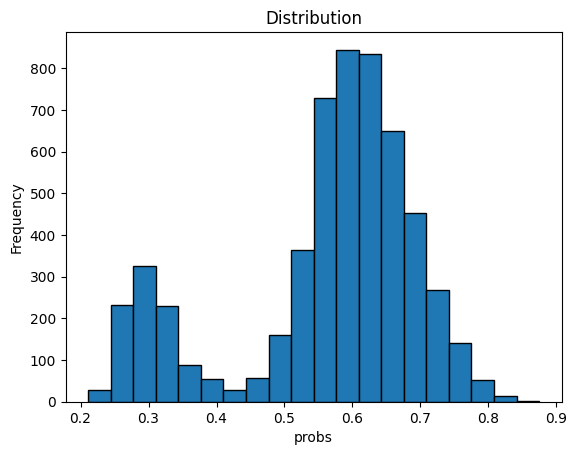

In [21]:
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

In [22]:
freqs = {}
for pd in good_prompts_months:
    if pd['S1'] not in freqs:
        freqs[pd['S1']] = 1
    else:
        freqs[pd['S1']] += 1
freqs

{'January': 128,
 'February': 128,
 'March': 128,
 'April': 128,
 'May': 128,
 'June': 128,
 'July': 128,
 'August': 128}

In [23]:
freqs = {}
for pd in good_prompts:
    if pd['S1'] not in freqs:
        freqs[pd['S1']] = 1
    else:
        freqs[pd['S1']] += 1
freqs

{'one': 128,
 'two': 128,
 'three': 128,
 'four': 128,
 'five': 128,
 'six': 128,
 'seven': 128,
 'eight': 128}

# numwords, months- lost

In [24]:
# List of common, short words which are likely to be single tokens in GPT-2
common_words = [
    "Apple", "Ball", "Car", "Dog", "Egg", "Fish", "Gold", "Hat", "Ink", "Jar",
    "Kite", "Lamp", "Moon", "Nest", "Owl", "Pig", "Quilt", "Rat", "Sun", "Tree",
    "Umbrella", "Vase", "Wolf", "Yarn", "Zip", "Bird", "Cat", "Drum", "Frog",
    "Grape", "House", "Ice", "Juice", "Key", "Leaf", "Map", "Nut", "Orange",
    "Piano", "Queen", "Ring", "Star", "Train", "Van", "Whale", "Xylophone",
    "Yacht", "Zebra", "Ax", "Box", "Cow", "Desk", "Ear", "Fan", "Gate", "Hill",
    "Iron", "Joke", "King", "Lion", "Milk", "Nose", "Oil", "Pen", "Quiz", "Rose",
    "Shoe", "Tail", "Vine", "Wall", "Year", "Ant", "Bug", "Corn", "Duck", "Fire",
    "Grass", "Hand", "Island", "Jam", "Knee", "Lake", "Mouse", "Nail", "Pear",
    "Quack", "Road", "Sand", "Tent", "Valley", "Wind", "Yard", "Arm", "Boat",
    "Cake", "Door", "Eye", "Flag", "Horse", "Jeep", "Knife", "Light", "Mountain",
    "Night", "Ocean", "Plate", "Queen", "Rain", "Snow", "Tree", "Umbrella",
    "Valley", "Window", "Yogurt", "Zoo", "Balloon", "Bicycle", "Car", "Doll", "Eagle", "Flag", "Giraffe", "Helmet", "Igloo", "Jacket",
    "Kite", "Lion", "Monkey", "Nest", "Oven", "Pencil", "Quill", "Rabbit", "Star", "Truck",
    "Umbrella", "Violin", "Whale", "Xylophone", "Yak", "Zebra", "Apple", "Banana", "Camera", "Drum",
    "Elephant", "Fork", "Glass", "House", "Island", "Jewel", "Kangaroo", "Lamp", "Mountain", "Notebook",
    "Orange", "Piano", "Queen", "Rose", "Snake", "Tiger", "Urn", "Vase", "Window", "Xerox",
    "Yoyo", "Zipper", "Anchor", "Brush", "Clock", "Dress", "Easel", "Fan", "Guitar", "Harp",
    "Ink", "Jug", "Knife", "Leaf", "Mirror", "Nut", "Owl", "Penguin", "Quartz", "Ring",
    "Spoon", "Table", "Ukulele", "Van", "Watch", "X-ray", "Yarn", "Zucchini", "Artichoke", "Broccoli",
    "Cup", "Desk", "Egg", "Fridge", "Grape", "Hose", "Iris", "Jackal", "Kettle", "Lizard",
    "Mango", "Napkin", "Ostrich", "Peacock", "Quokka", "Racoon", "Seal", "Tulip", "Urchin", "Violet",
    "apple", "ball", "chair", "desk", "elephant", "flower", "guitar", "hat", "jug", "kite",
    "lamp", "mirror", "orange", "piano", "quilt", "ring", "television", "umbrella", "violin", "watch",
    "yacht", "zebra", "book", "cup", "drone", "fridge", "gloves", "helmet", "igloo", "jacket",
    "key", "lemon", "mug", "nail", "octopus", "pillow", "robot", "spoon", "tree", "unicorn",
    "vase", "wheel", "yo-yo", "zipper", "backpack", "camera", "dumbbell", "envelope", "flashlight", "goggles",
    "hammer", "ink", "jeans", "ladder", "microphone", "nest", "owl", "penguin", "quill", "ruler",
    "scissors", "tent", "volcano", "wallet", "yogurt", "zucchini", "accordion", "bicycle", "candle", "dice",
    "egg", "fan"
    ]

In [25]:
random_single_word_objects = [obj.capitalize() for obj in common_words]
random_single_word_objects = filter_to_single_token(model, random_single_word_objects)
len(random_single_word_objects)

100

In [26]:
prompts_list = generate_prompts_list(0, 8, random_single_word_objects, 'lost')

In [27]:
prompts_list_months = replace_nw_seqtype(prompts_list, 'months')

In [28]:
good_prompts, good_prompts_months, all_probs = get_good_prompts_nw_months(model, prompts_list, prompts_list_months)

8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024


In [29]:
with open('nw_prompts_lost.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)
files.download('nw_prompts_lost.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
with open('months_prompts_lost.pkl', 'wb') as file:
    pickle.dump(good_prompts_months, file)
files.download('months_prompts_lost.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Distribution')

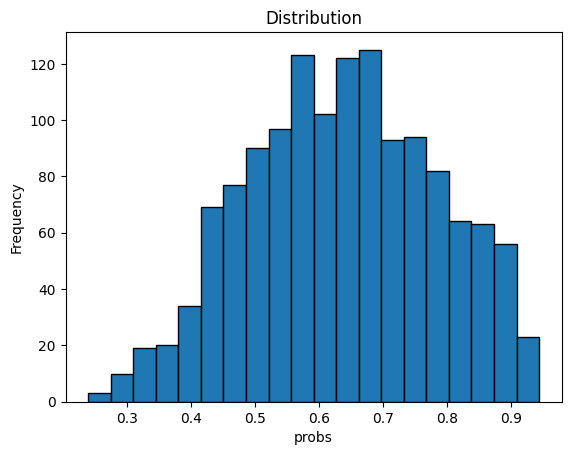

In [31]:
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

In [32]:
freqs = {}
for pd in good_prompts_months:
    if pd['S1'] not in freqs:
        freqs[pd['S1']] = 1
    else:
        freqs[pd['S1']] += 1
freqs

{'January': 128,
 'February': 128,
 'March': 128,
 'April': 128,
 'May': 128,
 'June': 128,
 'July': 128,
 'August': 128}

In [33]:
freqs = {}
for pd in good_prompts:
    if pd['S1'] not in freqs:
        freqs[pd['S1']] = 1
    else:
        freqs[pd['S1']] += 1
freqs

{'one': 128,
 'two': 128,
 'three': 128,
 'four': 128,
 'five': 128,
 'six': 128,
 'seven': 128,
 'eight': 128}

# numwords, months- done

In [34]:
prompts_list = generate_prompts_list(0, 8, random_single_word_objects, 'done')

In [35]:
prompts_list_months = replace_nw_seqtype(prompts_list, 'months')

In [36]:
good_prompts, good_prompts_months, all_probs = get_good_prompts_nw_months(model, prompts_list, prompts_list_months)

8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024


In [37]:
with open('nw_prompts_done.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)
files.download('nw_prompts_done.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
with open('months_prompts_done.pkl', 'wb') as file:
    pickle.dump(good_prompts_months, file)
files.download('months_prompts_done.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Distribution')

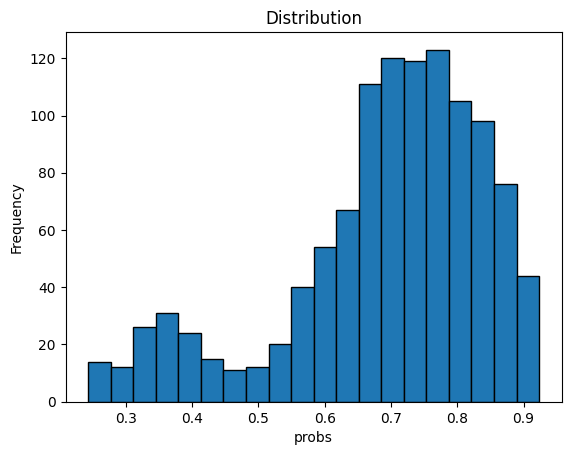

In [39]:
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

In [40]:
freqs = {}
for pd in good_prompts_months:
    if pd['S1'] not in freqs:
        freqs[pd['S1']] = 1
    else:
        freqs[pd['S1']] += 1
freqs

{'January': 128,
 'February': 128,
 'March': 128,
 'April': 128,
 'May': 128,
 'June': 128,
 'July': 128,
 'August': 128}

In [41]:
freqs = {}
for pd in good_prompts:
    if pd['S1'] not in freqs:
        freqs[pd['S1']] = 1
    else:
        freqs[pd['S1']] += 1
freqs

{'one': 128,
 'two': 128,
 'three': 128,
 'four': 128,
 'five': 128,
 'six': 128,
 'seven': 128,
 'eight': 128}

# numerals- names

In [42]:
file_name = 'nw_prompts_names.pkl'
with open(file_name, 'rb') as file:
    prompts_list = pickle.load(file)

In [43]:
prompts_list = replace_nw_seqtype(prompts_list, 'numerals')

In [44]:
good_prompts, all_probs = get_good_prompts_numerals(model, prompts_list)

In [45]:
with open('digits_prompts_names.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)
files.download('digits_prompts_names.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Distribution')

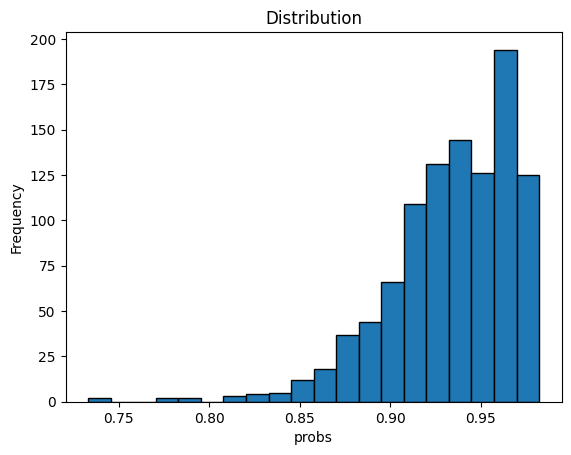

In [46]:
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

# numerals- lost

In [47]:
file_name = 'nw_prompts_lost.pkl'
with open(file_name, 'rb') as file:
    prompts_list = pickle.load(file)

In [48]:
prompts_list = replace_nw_seqtype(prompts_list, 'numerals')

In [49]:
good_prompts, all_probs = get_good_prompts_numerals(model, prompts_list)

In [50]:
with open('digits_prompts_lost.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)
files.download('digits_prompts_lost.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Distribution')

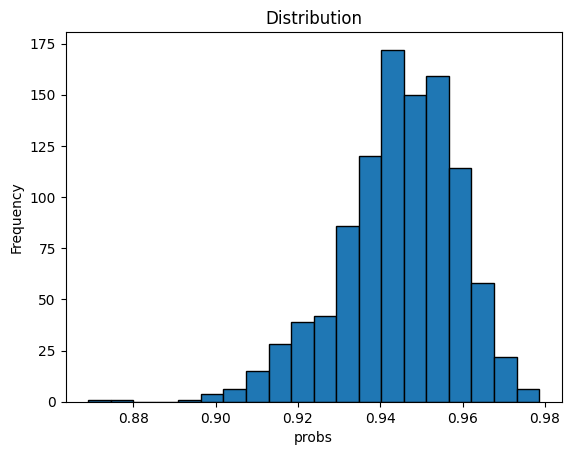

In [51]:
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

# numerals- done

In [52]:
file_name = 'nw_prompts_done.pkl'
with open(file_name, 'rb') as file:
    prompts_list = pickle.load(file)

In [53]:
prompts_list = replace_nw_seqtype(prompts_list, 'numerals')

In [54]:
good_prompts, all_probs = get_good_prompts_numerals(model, prompts_list)

In [55]:
with open('digits_prompts_done.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)
files.download('digits_prompts_done.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Distribution')

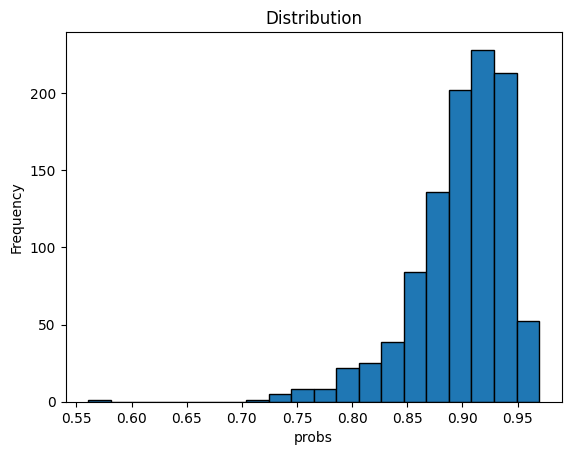

In [56]:
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')